In [4]:
import numpy as np
import coop_post_processing as cpp
import healpy as hp
import warnings
warnings.filterwarnings('ignore')
from astropy import wcs
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import matplotlib as mpl
font = {'size'   : 16}
mpl.rc('font', **font)
import coop_setup_funcs as csf

In [5]:
# # get the redmapper-like clusters
# import websky as ws
# ra, dec, z, chi, mass = ws.read_halos("/mnt/raid-cita/mlokken/pkpatch/halos_fullsky_M_gt_1E13.npy")


In [6]:
# thetaphi_list = csf.radec_to_thetaphi_sliced(ra, dec, z, minz=0.4, maxz=0.47, slice_width=200)[0][0]

# np.savetxt("/mnt/raid-cita/mlokken/pkpatch/number_density_maps/fullsky/1pt5E12_to_1E15_msun/maglim_masked/Mgt13_halos_1600_1800Mpc.txt", thetaphi_list)

In [7]:
odmap_full = hp.read_map("/mnt/raid-cita/mlokken/data/number_density_maps/maglim/odmap_zbin3.fits")

In [8]:
def calc_offsets(rot_angle_pct, rot_angle_all):
    diffs = []
    for i in range(len(rot_angle_pct)):
        a = rot_angle_pct[i] - rot_angle_all[i]
        a = (a + np.pi) % (2*np.pi) - np.pi
        diffs.append(abs(a))
    diffs = np.asarray(diffs)
    diffs[diffs>(np.pi/2.)]-=np.pi
    diffs = (np.abs(diffs)*u.rad).to(u.deg)
    return diffs


def get_vector_components(rot_angle):
    U_arr = np.zeros(len(rot_angle))
    V_arr = np.zeros(len(rot_angle))
    m = 0
    for r in rot_angle:

        if (r <= np.pi/2.) or (r > 3*np.pi/2.):
            U = 1/np.sqrt(1+np.tan(r)**2)
        else:
            U = -1/np.sqrt(1+np.tan(r)**2)
        V = U * np.tan(r)
        U_arr[m] = U
        V_arr[m] = V
        m += 1
    return U_arr, V_arr

def smallpatch(odmap, odmap_ref, ralist, declist, angles, cl_idx, scale):
    patch = hp.cartview(odmap, lonra=[ralist[cl_idx]-2, ralist[cl_idx]+2], latra=[declist[cl_idx]-2, declist[cl_idx]+2], return_projected_map=True)
    ref_patch = hp.cartview(odmap_ref, lonra=[ralist[cl_idx]-2, ralist[cl_idx]+2], latra=[declist[cl_idx]-2, declist[cl_idx]+2], return_projected_map=True)
    fig, ax = plt.subplots(figsize=[7,7])
    m = ax.imshow(np.flipud(patch),vmin=-1,vmax=1)
    ax.contour(np.flipud(ref_patch), c='white', zorder=1)
    U_arr, V_arr = get_vector_components([angles[cl_idx]])
    ax.quiver(patch.shape[0]/2., patch.shape[1]/2., -U_arr, V_arr, width=0.005, color = 'k', scale_units = 'inches', scale = 25/scale, zorder=2)
    ax.quiver(patch.shape[0]/2., patch.shape[1]/2., U_arr, -V_arr, width=0.005, color = 'k', scale = 25/scale, scale_units = 'inches', label=str(scale), zorder=2)
    ax.scatter(patch.shape[0]/2., patch.shape[1]/2., s=20,color='w', zorder=3)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(m)   
    plt.show()
    plt.clf()
    return 

In [3]:
scales = [5,10,15,20,25,30,35] #,40,45
angles = []

for scale in scales:
    angle, ra, dec = cpp.peakinfo_radec("/mnt/scratch-lustre/mlokken/stacking/data_ndmap/theta_of_r/{:s}Mpc_nu2to3_ept3topt4.fits".format(str(scale)))
    angles.append(angle)


In [4]:
# Load 20 Mpc-smoothed map
f20 = hp.read_map("/mnt/raid-cita/mlokken/data/number_density_maps/maglim/odmap_z_0pt55_0pt7_smth_20Mpc_29a.fits")


In [5]:
width = cosmo.kpc_comoving_per_arcmin((0.55+0.7)/2.).to(u.Mpc/u.deg)

In [19]:
width*4

<Quantity 164.1223342 Mpc / deg>

[400. 320.]
[ 50. -30.]
[-0.125  0.125]


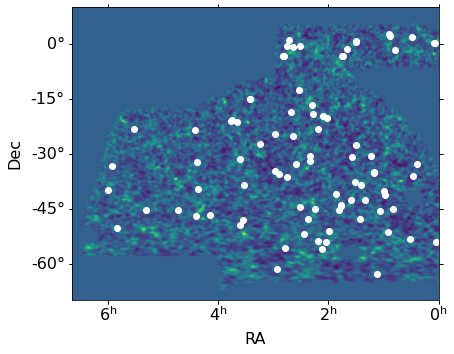

In [8]:
# Plot all clusters
lonmin=-0
lonmax=100
latmin=-70
latmax=10
od_map_flat = hp.cartview(f20, lonra=[lonmin,lonmax], latra=[latmin,latmax], return_projected_map=True)

w = wcs.WCS(naxis=2)
height = float(od_map_flat.shape[0])
length = float(od_map_flat.shape[1])
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmax-latmin)/height, (latmin+latmax)/2.
w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]

# Make the figure
Xpix,Ypix = w.all_world2pix(ra[ra<180],dec[ra<180],0)
nrows = 1
ax1 = plt.subplot(nrows, 1, 1, projection=w)
ax1.imshow(od_map_flat)
ax1.set_xticks([])
ax1.set_xticklabels([])
cm = plt.get_cmap("coolwarm")

ax1.scatter(Xpix,Ypix,color='w')
#     ax1.quiver(Xpix,Ypix, U_arr, -V_arr, width=0.0005*scales[i], color = cm(i/len(scales)), scale = 20/scales[i], scale_units = 'inches', label=str(scales[i]))
# plt.legend(loc='lower right')
plt.xlabel("RA")
plt.ylabel("Dec")


[400. 400.]
[13.24951173  2.38004281]
[-0.005  0.005]


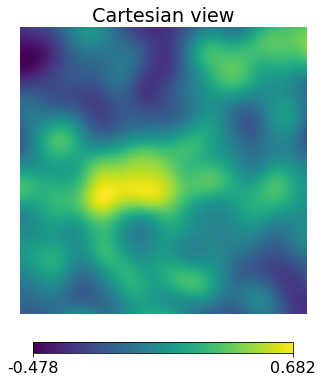

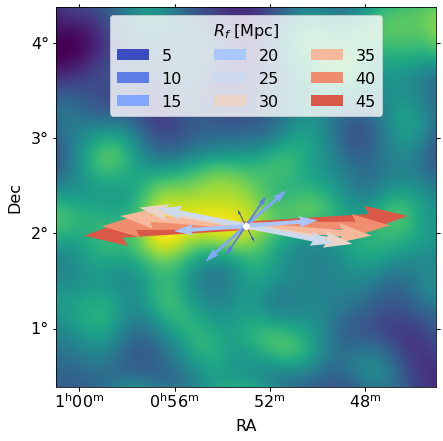

In [16]:
# Pick a cluster
idx   = 41
lonmin=ra[idx]-2
lonmax=ra[idx]+2
latmin=dec[idx]-1.7
latmax=dec[idx]+2.3
od_map_flat = hp.cartview(f20, lonra=[lonmin,lonmax], latra=[latmin,latmax], return_projected_map=True)

w = wcs.WCS(naxis=2)
Xpix,Ypix   = w.all_world2pix(ra[idx],dec[idx],0)
height = float(od_map_flat.shape[0])
length = float(od_map_flat.shape[1])
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmax-latmin)/height, (latmin+latmax)/2.
w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]

# Make the figure
Xpix,Ypix = w.all_world2pix(ra[idx],dec[idx],0)
fig = plt.figure(figsize=(7,7))
nrows = 1
ax1 = plt.subplot(nrows, 1, 1, projection=w)
ax1.imshow(od_map_flat)
ax1.set_xticks([])
ax1.set_xticklabels([])
cm = plt.get_cmap("coolwarm")
for i in np.arange(len(scales))[::-1]:
    U_arr, V_arr = get_vector_components([angles[i][idx]])
    ax1.quiver(Xpix,Ypix, -U_arr, V_arr, width=0.0005*scales[i], color = cm(i/len(scales)), scale_units = 'inches', scale = 20/scales[i])
    ax1.quiver(Xpix,Ypix, U_arr, -V_arr, width=0.0005*scales[i], color = cm(i/len(scales)), scale = 20/scales[i], scale_units = 'inches', label=str(scales[i]))
handles, labels = ax1.get_legend_handles_labels()
ax1.scatter(Xpix,Ypix,c='w')
ax1.legend(handles[::-1], labels[::-1], title=r'$R_f$ [Mpc]', loc='upper center', ncol=3)
plt.xlabel("RA")
plt.ylabel("Dec")
# plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/theta_r_arrow_vis.png")


In [11]:
mask = hp.read_map("/mnt/raid-cita/mlokken/data/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask_hpx_4096.fits")

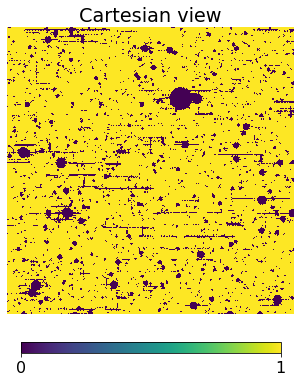

In [17]:
flatmap = hp.cartview(mask, lonra=[lonmin,lonmax], latra=[latmin,latmax])

In [18]:
# Load maps
f5  = hp.read_map("/mnt/raid-cita/mlokken/data/number_density_maps/maglim/odmap_z_0pt55_0pt7_smth_5Mpc_7a.fits")
f10 = hp.read_map("/mnt/raid-cita/mlokken/data/number_density_maps/maglim/odmap_z_0pt55_0pt7_smth_10Mpc_14a.fits")
f15 = hp.read_map("/mnt/raid-cita/mlokken/data/number_density_maps/maglim/odmap_z_0pt55_0pt7_smth_15Mpc_21a.fits")
f25 = hp.read_map("/mnt/raid-cita/mlokken/data/number_density_maps/maglim/odmap_z_0pt55_0pt7_smth_25Mpc_36a.fits")
f30 = hp.read_map("/mnt/raid-cita/mlokken/data/number_density_maps/maglim/odmap_z_0pt55_0pt7_smth_30Mpc_43a.fits")

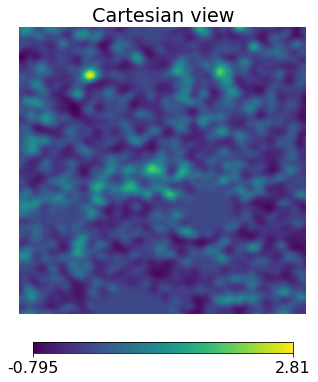

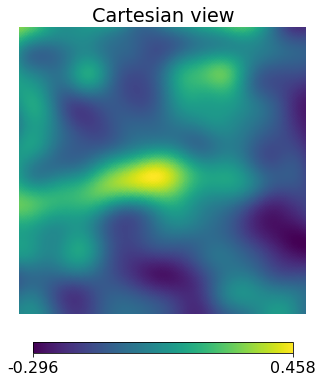

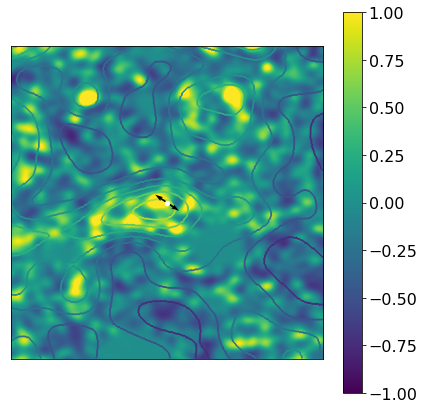

<Figure size 432x288 with 0 Axes>

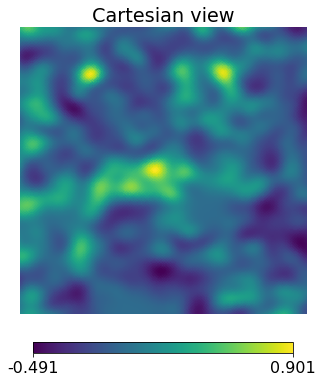

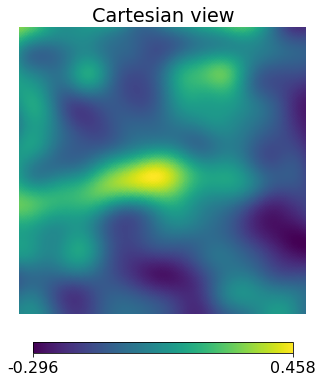

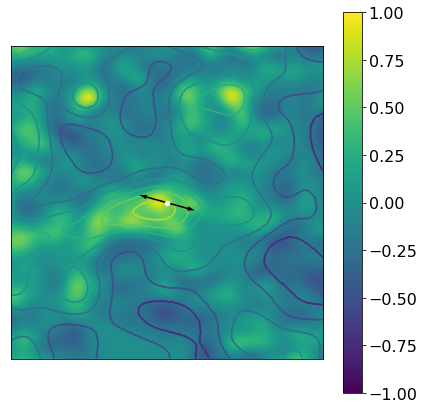

<Figure size 432x288 with 0 Axes>

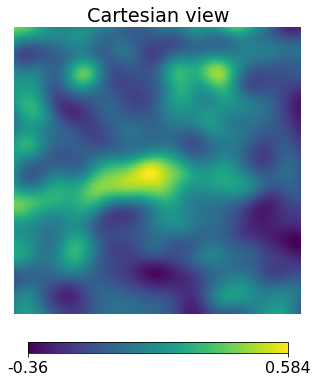

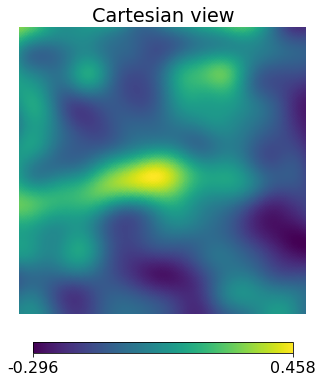

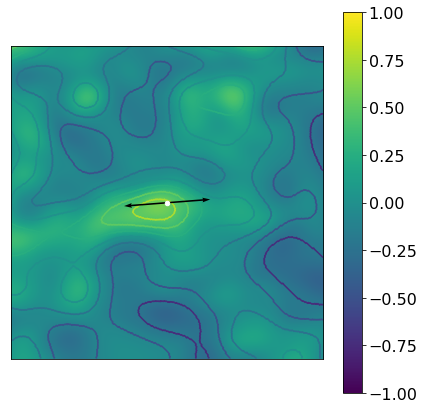

<Figure size 432x288 with 0 Axes>

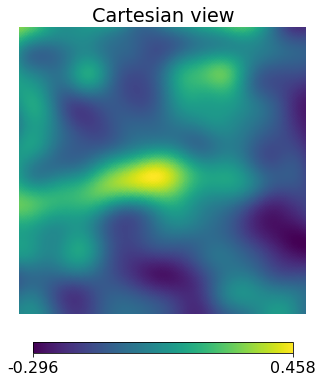

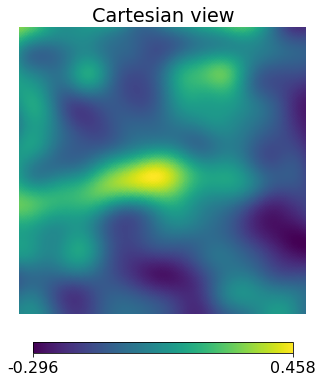

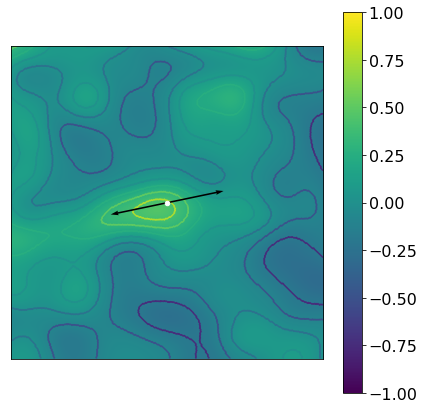

<Figure size 432x288 with 0 Axes>

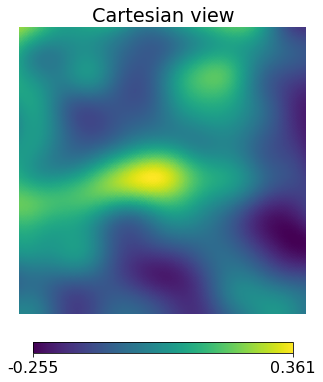

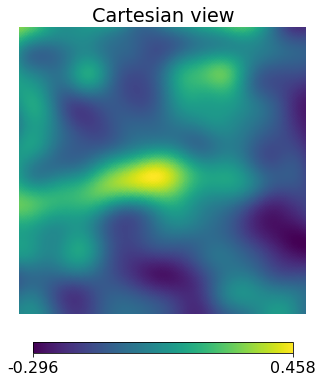

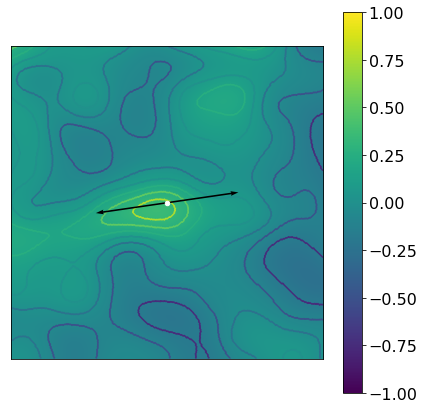

<Figure size 432x288 with 0 Axes>

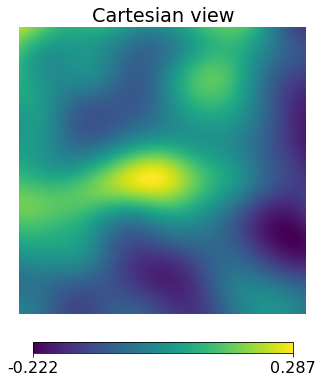

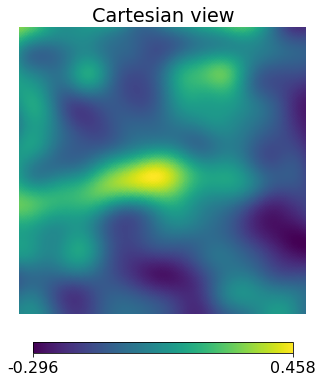

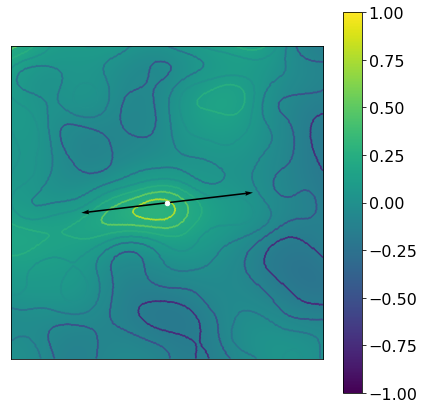

<Figure size 432x288 with 0 Axes>

In [176]:
smallpatch(f5,f20,ra, dec, angles[0,:], 37, 5)
smallpatch(f10,f20,ra, dec, angles[1,:], 37, 10)
smallpatch(f15,f20,ra, dec, angles[2,:], 37, 15)
smallpatch(f20,f20,ra, dec, angles[3,:], 37, 20)
smallpatch(f25,f20,ra, dec, angles[4,:], 37, 25)
smallpatch(f30,f20,ra, dec, angles[5,:], 37, 30)

In [90]:
angles = np.asarray(angles)

In [92]:
# get all offsets wrt 0s
offs_list = []
for i in range(len(scales)):
    offs = calc_offsets(angles[i,:],angles[0,:])
    offs_list.append(offs)

In [93]:
offs_array = np.asarray(offs_list)

Text(0, 0.5, '$\\theta$')

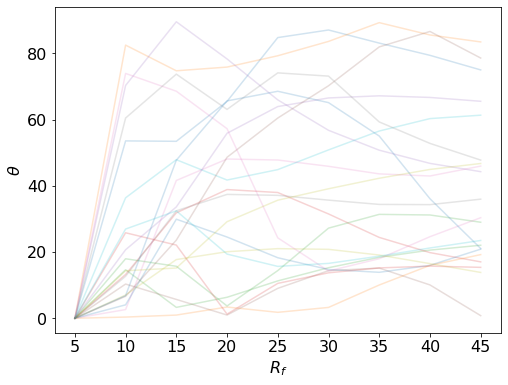

In [95]:
# theta of r for whole population
ncl = len(angles[0])
plt.figure(figsize=[8,6])

for i in range(ncl):
    plt.plot(scales, offs_array[:,i], alpha=.2)
    if i==20:
        break
plt.xlabel(r"$R_f$")
plt.ylabel(r"$\theta$")
# plt.title(r"$\nu(R_f)$ for 1000 cluster locations")
# for i in range(len(angles[0])):
#     plt.plot(scales, angles[])

In [96]:
offset_bw_scales = []
stds = []
for i in range(1,len(scales)):
    steps = calc_offsets(angles[i,:],angles[i-1,:]) # take the difference between that scale and the one down
    offset_bw_scales.append(np.average(steps.value))
    stds.append(np.std(steps.value))

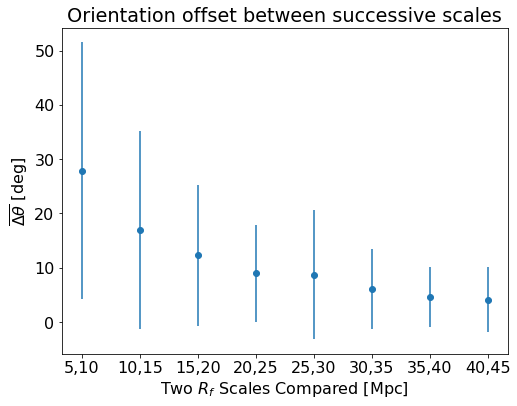

In [179]:
plt.figure(figsize=[8,6])
plt.errorbar(scales[1:], offset_bw_scales, yerr=stds, fmt='o')
labels=['5,10','10,15','15,20','20,25','25,30', '30,35','35,40','40,45']
plt.xticks([10,15,20,25,30,35,40,45], labels=labels)
plt.xlabel(r"Two $R_f$ Scales Compared [Mpc]")
plt.ylabel(r"$\overline{\Delta \theta}$ [deg]")
plt.title("Orientation offset between successive scales")
plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/theta_offset_R.png")

# Now let's do the same with Websky
Make sure this is not an effect of the mask

In [9]:
scales = [5,10,15,20,25,30,35, 40] #,40,45

for i, scale in enumerate(scales):
    angle, ra, dec = cpp.peakinfo_radec("/mnt/scratch-lustre/mlokken/stacking/PeakPatch_halomap/orient_by_1pt5E12_to_1E15_msun_halos/theta_of_r/{:s}Mpc_nu2to3_ept3topt4.fits".format(str(scale)))
    print(len(angle))
    if i==0:
        angles = angle
    else:
        angles = np.vstack([angles, angle])


8669
8669
8669
8669
8669
8669
8669
8669


In [10]:

# get all offsets wrt 0s
offs_list = []
for i in range(len(scales)):
    offs = calc_offsets(angles[i,:],angles[0,:])
    offs_list.append(offs)
offs_array = np.asarray(offs_list)

In [11]:
offset_bw_scales = []
stds = []
for i in range(len(scales[1:])):
    steps = calc_offsets(angles[i,:],angles[i-1,:]) # take the difference between that scale and the one down
    offset_bw_scales.append(np.average(steps.value))
    stds.append(np.std(steps.value))

Text(0.5, 1.0, 'Orientation offset between successive scales, Websky')

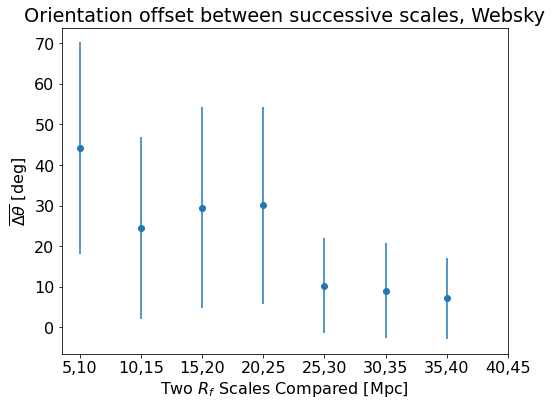

In [12]:
plt.figure(figsize=[8,6])
plt.errorbar(scales[1:], offset_bw_scales, yerr=stds, fmt='o')
labels=['5,10','10,15','15,20','20,25','25,30', '30,35','35,40','40,45']
plt.xticks([10,15,20,25,30,35,40,45], labels=labels)
plt.xlabel(r"Two $R_f$ Scales Compared [Mpc]")
plt.ylabel(r"$\overline{\Delta \theta}$ [deg]")
plt.title("Orientation offset between successive scales, Websky")
# plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/theta_offset_R_websky.png")

In [ ]:
# Load 20 Mpc-smoothed map
f20 = hp.read_map("/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/1pt5E12_to_1E15_msun/odmap_all_z_0pt55_0pt7_smth_20Mpc_29a.fits")
